In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = os.listdir('/content/drive/MyDrive/three_final')
print(dataset_path)

['sad', 'neutral', 'happy']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plot
import pandas as pd
import matplotlib.pyplot as plt
import copy
from tqdm.notebook import tqdm

import time
import os


In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu118
True


In [ ]:
import os
import random
import shutil

# 분할된 데이터셋의 저장 경로
output_dir = '/content/drive/MyDrive/three_for_resnet'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

In [ ]:
dataset_path = '/content/drive/MyDrive/three_final'

In [ ]:
# 분할 비율 설정
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# 폴더 생성
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 클래스 리스트 추출
class_names = os.listdir(dataset_path) #['sad', 'neutral', 'happy']
print(class_names)

['sad', 'neutral', 'happy']


In [ ]:
# 각 클래스마다 이미지 분할 및 이동
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name) #'/content/drive/MyDrive/three_final/sad'
    images = os.listdir(class_dir)
    num_images = len(images)
    print(class_dir, num_images)

    # 이미지를 무작위로 섞음
    random.shuffle(images)

    # 분할된 인덱스 계산
    train_end = int(train_ratio * num_images)
    val_end = int((train_ratio + val_ratio) * num_images)

    # 분할된 이미지들을 각각의 폴더로 이동
    for i, image in enumerate(images):
        src_path = os.path.join(class_dir, image)  #'/content/drive/MyDrive/three_final/sad',image

        if i < train_end:
            dst_dir = os.path.join(train_dir, class_name)
        elif i < val_end:
            dst_dir = os.path.join(val_dir, class_name)
        else:
            dst_dir = os.path.join(test_dir, class_name)

        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, image)
        shutil.copy(src_path, dst_path)

In [ ]:
#Data Transformation and Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [ ]:
# plt.ion()
# csv_file = pd.read_csv('./Training_set_food.csv')

# labels = list(dict.fromkeys(csv_file['label']))
labels = ['happy','neutral','sad']


In [ ]:
data_dir = '/content/drive/MyDrive/three_for_resnet'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

image_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=1) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

['happy', 'neutral', 'sad']
using device: cuda:0


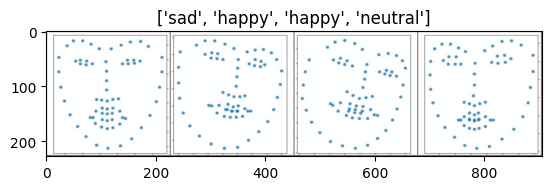

In [ ]:
def imshow(imgs, title=None):
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(image_dataloader['train']))

imgs = torchvision.utils.make_grid(inputs)

imshow(imgs, title=[class_names[x] for x in classes])

### Train functions and its pipeline

In [ ]:
def train(model, criterion, optimizer, scheduler, num_epochs=30, early_stopping=True):
    last_loss = 100
    patience = 8
    trigger_times = 0

    total_start = time.time()

    total_train_accuracy = []
    total_train_loss = []
    total_val_accuracy = []
    total_val_loss = []

    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        start = time.time()
        print('Epoch {} / {}'.format(epoch, num_epochs-1))
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #for inputs, labels in tqdm(image_dataloader[phase]):
            for index, (inputs, labels) in enumerate(image_dataloader[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.float() / dataset_sizes[phase]

            if phase == 'train':
                total_train_loss.append(epoch_loss)
                total_train_accuracy.append(epoch_accuracy)
            if phase == 'val':
                total_val_loss.append(epoch_loss)
                total_val_accuracy.append(epoch_accuracy)

            print('{} Loss: {:.5f} Accuracy: {:.5f}'.format(phase, epoch_loss, epoch_accuracy))

            if phase == 'val' and epoch_accuracy > best_acc:
                best_acc = epoch_accuracy
                best_loss = epoch_loss
                best_model_weight = copy.deepcopy(model.state_dict())

            if early_stopping and phase == 'val':
                if last_loss < epoch_loss:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print('Early stopping at epoch {}'.format(epoch))
                        total_time_elapsed = np.round(time.time() - total_start, 3)
                        print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
                        print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))
                        model.load_state_dict(best_model_weight)
                        return model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss
                else:
                    trigger_times = 0
                last_loss = epoch_loss

        #save on every 10 epochs
        if epoch % 10 == 0:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'epoch': epoch
            }, '/content/drive/MyDrive/weights/ResNet18_epoch_{}.pt'.format(epoch))

        end = np.round(time.time() - start, 3)
        print('Epoch {}: {}s\n'.format(epoch, end))

    total_time_elapsed = np.round(time.time() - total_start, 3)
    print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
    print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))

    model.load_state_dict(best_model_weight)
    return model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss

Visualization for validation set

In [ ]:
def visualize_model(model, num_imgs=4):
    train_phase = model.training
    model.eval()
    total_images_processed = 0
    fig = plt.figure()

    with torch.no_grad():
        #for inputs, labels in tqdm(image_dataloader['val']):
        for index, (inputs, labels) in enumerate(image_dataloader['val']):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                total_images_processed += 1
                ax = plt.subplot(num_imgs//2, 2, total_images_processed)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if total_images_processed == num_imgs:
                    model.train(mode=train_phase)
                    return
        model.train(mode=train_phase)


Network structure

In [ ]:
#Load pretrained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [ ]:
model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss = train(model, criterion, optimizer, \
                                                                                          learning_rate_scheduler, num_epochs=200, early_stopping=True)

Epoch 0 / 199
--------------------
train Loss: 2.67600 Accuracy: 0.48700
val Loss: 1.20225 Accuracy: 0.65283
Epoch 0: 1125.398s

Epoch 1 / 199
--------------------
train Loss: 2.54418 Accuracy: 0.53306
val Loss: 1.14411 Accuracy: 0.68146
Epoch 1: 38.448s

Epoch 2 / 199
--------------------
train Loss: 2.59400 Accuracy: 0.52733
val Loss: 1.87429 Accuracy: 0.57981
Epoch 2: 38.464s

Epoch 3 / 199
--------------------
train Loss: 2.47670 Accuracy: 0.53961
val Loss: 1.32942 Accuracy: 0.64782
Epoch 3: 38.176s

Epoch 4 / 199
--------------------
train Loss: 2.63831 Accuracy: 0.53859
val Loss: 2.76860 Accuracy: 0.56263
Epoch 4: 38.016s

Epoch 5 / 199
--------------------
train Loss: 2.70632 Accuracy: 0.53961
val Loss: 3.38230 Accuracy: 0.50322
Epoch 5: 37.823s

Epoch 6 / 199
--------------------
train Loss: 2.78455 Accuracy: 0.53449
val Loss: 1.30148 Accuracy: 0.66714
Epoch 6: 38.211s

Epoch 7 / 199
--------------------
train Loss: 2.71751 Accuracy: 0.56336
val Loss: 3.00983 Accuracy: 0.53329


KeyboardInterrupt: ignored